## EJERCICIO 2 CLASIFICACIÓN
Deberá entrenar un modelo de clasificación para generar las respuestas que hará el servicio.

### IMPORTAR LIBRERIAS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

from config.config_file import PATH_ALFA_BETHA_FILE, PATH_CLASSIFIER_MODEL, PATH_SCALER_MODEL

In [2]:
data = pd.read_csv(PATH_ALFA_BETHA_FILE, sep=',')
data.head()

,autoID,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
0,7590-VHVEG,0,Yes,No,No,No phone service,No,Yes,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,Alpha
1,5575-GNVDE,0,No,No,Yes,No,Yes,No,Yes,No,One year,No,Mailed check,56.95,1889.5,Alpha
2,3668-QPYBK,0,No,No,Yes,No,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Betha
3,7795-CFOCW,0,No,No,No,No phone service,Yes,No,Yes,Yes,One year,No,Bank transfer (automatic),42.30,1840.75,Alpha
4,9237-HQITU,0,No,No,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Betha


In [3]:
data.columns

Index(['autoID', 'SeniorCity', 'Partner', 'Dependents', 'Service1', 'Service2',
       'Security', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Charges', 'Demand',
       'Class'],
      dtype='object')

#### Verificación de tipo de datos y estadística básica

In [4]:
data.dtypes

autoID               object
SeniorCity            int64
Partner              object
Dependents           object
Service1             object
Service2             object
Security             object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
Contract             object
PaperlessBilling     object
PaymentMethod        object
Charges             float64
Demand               object
Class                object
dtype: object

In [5]:
print('\nEstadística de datos en el DataFrame:')  
data.describe()


Estadística de datos en el DataFrame:


,SeniorCity,Charges
count,7043.000000,7043.000000
mean,0.162147,64.761692
std,0.368612,30.090047
min,0.000000,18.250000
25%,0.000000,35.500000
50%,0.000000,70.350000
75%,0.000000,89.850000
max,1.000000,118.750000


#### Verificación de datos nulos/faltantes

In [6]:
print("Datos nulos por columna:")
print(data.isnull().sum())

Datos nulos por columna:
autoID              0
SeniorCity          0
Partner             0
Dependents          0
Service1            0
Service2            0
Security            0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
PaymentMethod       0
Charges             0
Demand              0
Class               0
dtype: int64


### DESCRIPCIÓN DEL DATASET

In [7]:
unique_values = {col : data[col].unique() for col in data.columns}
for col, values in unique_values.items():
    print(f'columna:  {col}')
    print(f'Número devalores únicos: {len(values)}')
    print(f'Valores únicos: {values[:10]}')
    print('-' *50)

columna:  autoID
Número devalores únicos: 7043
Valores únicos: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' '7795-CFOCW' '9237-HQITU'
 '9305-CDSKC' '1452-KIOVK' '6713-OKOMC' '7892-POOKP' '6388-TABGU']
--------------------------------------------------
columna:  SeniorCity
Número devalores únicos: 2
Valores únicos: [0 1]
--------------------------------------------------
columna:  Partner
Número devalores únicos: 2
Valores únicos: ['Yes' 'No']
--------------------------------------------------
columna:  Dependents
Número devalores únicos: 2
Valores únicos: ['No' 'Yes']
--------------------------------------------------
columna:  Service1
Número devalores únicos: 2
Valores únicos: ['No' 'Yes']
--------------------------------------------------
columna:  Service2
Número devalores únicos: 3
Valores únicos: ['No phone service' 'No' 'Yes']
--------------------------------------------------
columna:  Security
Número devalores únicos: 3
Valores únicos: ['No' 'Yes' 'No internet service']
-----------

### Los datos contenidos en la tabla presentan:
7043 rows × 15 columns
| **Campo**          | **Descripción**                                      | **Tipo de dato**  |
|--------------------|------------------------------------------------------|-------------------|
| autoID            | Identificador único                                  | `object`            |
| SeniorCity        | Valores booleanos (0 y 1)                            | `int64`        |
| Partner          | Indica si tiene pareja (yes/no)                       | `object`         |
| Dependents        | Indica si tiene dependientes (yes/no)                 | `object`         |
| Service1         | Servicio activado (yes/no)                             | `object`         |
| Service2         | Servicio activado (yes/no/'No phone service')          | `object`         |
| Security         | Seguridad activada (yes/no/'No internet service')      | `object`         |
| OnlineBackup     | Estado del respaldo en línea ('Yes'/'No'/'No internet service') | `object`         |
| DeviceProtection | Protección del dispositivo ('Yes'/'No'/'No internet service') | `object`         |
| TechSupport      | Soporte técnico disponible ('Yes'/'No'/'No internet service') | `object`         |
| Contract        | Tipo de contrato ('Month-to-month'/'One year'/'Two year') | `object`         |
| PaperlessBilling | Facturación sin papel ('Yes'/'No')                     | `object`         |
| PaymentMethod   | Método de pago ('Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)') | `object`         |
| Charges        | Costos asociados                                       | `float`            |
| Demand        | Nivel de demanda estimado                                | `object`            |
| Class          | Clasificación ('Alpha'/'Betha')                         | `object`         |


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   autoID            7043 non-null   object 
 1   SeniorCity        7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Service1          7043 non-null   object 
 5   Service2          7043 non-null   object 
 6   Security          7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  Contract          7043 non-null   object 
 11  PaperlessBilling  7043 non-null   object 
 12  PaymentMethod     7043 non-null   object 
 13  Charges           7043 non-null   float64
 14  Demand            7043 non-null   object 
 15  Class             7043 non-null   object 
dtypes: float64(1), int64(1), object(14)
memory

Demand está como un object se debe transformar a un número con punto flotante (float)

In [9]:
data['Demand'] = data['Demand'].replace(' ', 0).astype(float)
data['Demand'].dtype

dtype('float64')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   autoID            7043 non-null   object 
 1   SeniorCity        7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Service1          7043 non-null   object 
 5   Service2          7043 non-null   object 
 6   Security          7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  Contract          7043 non-null   object 
 11  PaperlessBilling  7043 non-null   object 
 12  PaymentMethod     7043 non-null   object 
 13  Charges           7043 non-null   float64
 14  Demand            7043 non-null   float64
 15  Class             7043 non-null   object 
dtypes: float64(2), int64(1), object(13)
memory

### Los datos contenidos en la tabla actualizados:
7043 rows × 15 columns
| **Campo**          | **Descripción**                                      | **Tipo de dato**  |
|--------------------|------------------------------------------------------|-------------------|
| autoID            | Identificador único                                  | `object`            |
| SeniorCity        | Valores booleanos (0 y 1)                            | `int64`        |
| Partner          | Indica si tiene pareja (yes/no)                       | `object`         |
| Dependents        | Indica si tiene dependientes (yes/no)                 | `object`         |
| Service1         | Servicio activado (yes/no)                             | `object`         |
| Service2         | Servicio activado (yes/no/'No phone service')          | `object`         |
| Security         | Seguridad activada (yes/no/'No internet service')      | `object`         |
| OnlineBackup     | Estado del respaldo en línea ('Yes'/'No'/'No internet service') | `object`         |
| DeviceProtection | Protección del dispositivo ('Yes'/'No'/'No internet service') | `object`         |
| TechSupport      | Soporte técnico disponible ('Yes'/'No'/'No internet service') | `object`         |
| Contract        | Tipo de contrato ('Month-to-month'/'One year'/'Two year') | `object`         |
| PaperlessBilling | Facturación sin papel ('Yes'/'No')                     | `object`         |
| PaymentMethod   | Método de pago ('Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)') | `object`         |
| Charges        | Costos asociados                                       | `float`            |
| Demand        | Nivel de demanda estimado                                | `float`            |
| Class          | Clasificación ('Alpha'/'Betha')                         | `object`         |


Como la variable autoID es un identificador único no es necesario para el modelo de clasificación

In [11]:
data = data.drop("autoID", axis=1)
data

,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
0,0,Yes,No,No,No phone service,No,Yes,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,Alpha
1,0,No,No,Yes,No,Yes,No,Yes,No,One year,No,Mailed check,56.95,1889.50,Alpha
2,0,No,No,Yes,No,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Betha
3,0,No,No,No,No phone service,Yes,No,Yes,Yes,One year,No,Bank transfer (automatic),42.30,1840.75,Alpha
4,0,No,No,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Betha
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,Alpha
7039,0,Yes,Yes,Yes,Yes,No,Yes,Yes,No,One year,Yes,Credit card (automatic),103.20,7362.90,Alpha
7040,0,Yes,Yes,No,No phone service,Yes,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,Alpha
7041,1,Yes,No,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Betha


### Variables categóricas 
Para entender mejor los datos y las variables, es necesario codificar las variables (one-hot encoding o label encoding), con el fin de detectar que categorías pueden afectar la precisión del modelo.

- Partner,
Dependents,
Service1,
Service2,
Security,
OnlineBackup,
DeviceProtection,
TechSupport,
Contract,
PaperlessBilling,
PaymentMethod,
Class, presentan valores entre "yes", "no" y entre otros, lo que las convierte en variables categóricas.

In [12]:
categorical_variables = data.select_dtypes(include=['object']).columns
print("Categorical variables:", categorical_variables)
for var in categorical_variables:
    print(f"\n{var}'s distribution:")
    print(data[var].value_counts(normalize=True))
    print('-' * 50)

Categorical variables: Index(['Partner', 'Dependents', 'Service1', 'Service2', 'Security',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Class'],
      dtype='object')

Partner's distribution:
Partner
No     0.516967
Yes    0.483033
Name: proportion, dtype: float64
--------------------------------------------------

Dependents's distribution:
Dependents
No     0.700412
Yes    0.299588
Name: proportion, dtype: float64
--------------------------------------------------

Service1's distribution:
Service1
Yes    0.903166
No     0.096834
Name: proportion, dtype: float64
--------------------------------------------------

Service2's distribution:
Service2
No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: proportion, dtype: float64
--------------------------------------------------

Security's distribution:
Security
No                     0.496663
Yes                    0.286668
No 

### Varibles numéricas o continuas

In [13]:
numerical_variables = data.select_dtypes(include=['int64', 'float64']).columns
print("Numerical variables:", numerical_variables)

Numerical variables: Index(['SeniorCity', 'Charges', 'Demand'], dtype='object')


### VISUALIZACIÓN DE LA DISTRIBUCIÓN DE DATOS

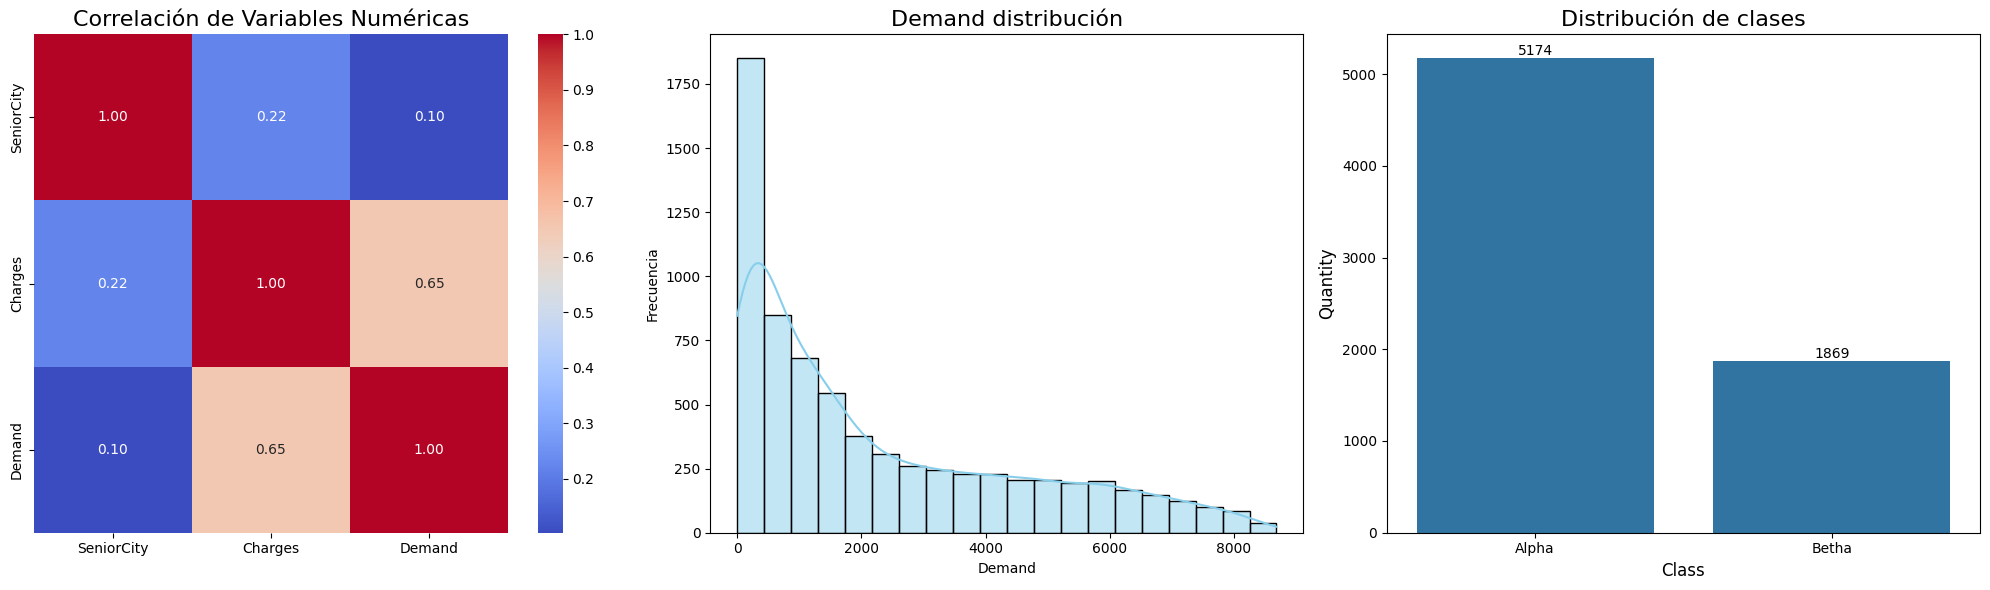

In [14]:

fig, axes = plt.subplots(1, 3, figsize=(20, 6))  

sns.heatmap(data[numerical_variables].corr(), annot=True, fmt='.2f', cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlación de Variables Numéricas', fontsize=16)

sns.histplot(data['Demand'], bins=20, kde=True, ax=axes[1], color='skyblue')
axes[1].set_title('Demand distribución', fontsize=16)
axes[1].set_xlabel('Demand')
axes[1].set_ylabel('Frecuencia')

ax = sns.barplot(x=data['Class'].value_counts().index, 
                y=data['Class'].value_counts().values)

for i, v in enumerate(data['Class'].value_counts().values):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Distribución de clases', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Quantity', fontsize=12)

plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

- En el mapa de calor se puede observar que las variables Charges y Demand tienen mayor correlación, pero la variable SeniorCity pero no presenta un valor de correlación significativo con respecto a Charges y Demand. Por lo tanto se puede eliminar ya que no influye significativamente en la predicción. 
- La gráfica de distribución muestra que la mayor parte de los valores de demanda se encuentran en el intervalo entre 0 a 2000.
- El gráfico de distribución de clases muestra un fuerte desequilibrio entre la clase 'Alpha' y 'Betha' lo que puede generar sesgo en el modelo de clasificación.

In [15]:
data = data.drop("SeniorCity", axis=1)
numerical_variables = numerical_variables.drop(["SeniorCity"])

print(data.head())
print(numerical_variables)

  Partner Dependents Service1          Service2 Security OnlineBackup  \
0     Yes         No       No  No phone service       No          Yes   
1      No         No      Yes                No      Yes           No   
2      No         No      Yes                No      Yes          Yes   
3      No         No       No  No phone service      Yes           No   
4      No         No      Yes                No       No           No   

  DeviceProtection TechSupport        Contract PaperlessBilling  \
0               No          No  Month-to-month              Yes   
1              Yes          No        One year               No   
2               No          No  Month-to-month              Yes   
3              Yes         Yes        One year               No   
4               No          No  Month-to-month              Yes   

               PaymentMethod  Charges   Demand  Class  
0           Electronic check    29.85    29.85  Alpha  
1               Mailed check    56.95  1889.50

### Conversión de variables categóricas en variables numéricas (método LabelEncoder)

In [16]:
l_encoder = LabelEncoder()

for var in categorical_variables:
    data[var] = l_encoder.fit_transform(data[var])
    
data.head()

,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
0,1,0,0,1,0,2,0,0,0,1,2,29.85,29.85,0
1,0,0,1,0,2,0,2,0,1,0,3,56.95,1889.50,0
2,0,0,1,0,2,2,0,0,0,1,3,53.85,108.15,1
3,0,0,0,1,2,0,2,2,1,0,0,42.30,1840.75,0
4,0,0,1,0,0,0,0,0,0,1,2,70.70,151.65,1


### Normalización de las variables numerícas

In [17]:
scaler = StandardScaler()
data[numerical_variables] = scaler.fit_transform(data[numerical_variables])

data[numerical_variables].head()

,Charges,Demand
0,-1.160323,-0.992611
1,-0.259629,-0.172165
2,-0.362660,-0.958066
3,-0.746535,-0.193672
4,0.197365,-0.938874


### Separación de los datos en X e y

In [18]:
X = data.drop(['Class'], axis=1)

y_class = data['Class']

### Balancear la variable `Class` con SMOTE

In [19]:
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y_class)

In [20]:
df_resampled = pd.DataFrame(X_balanced, columns=X.columns)
df_resampled['Class'] = y_balanced

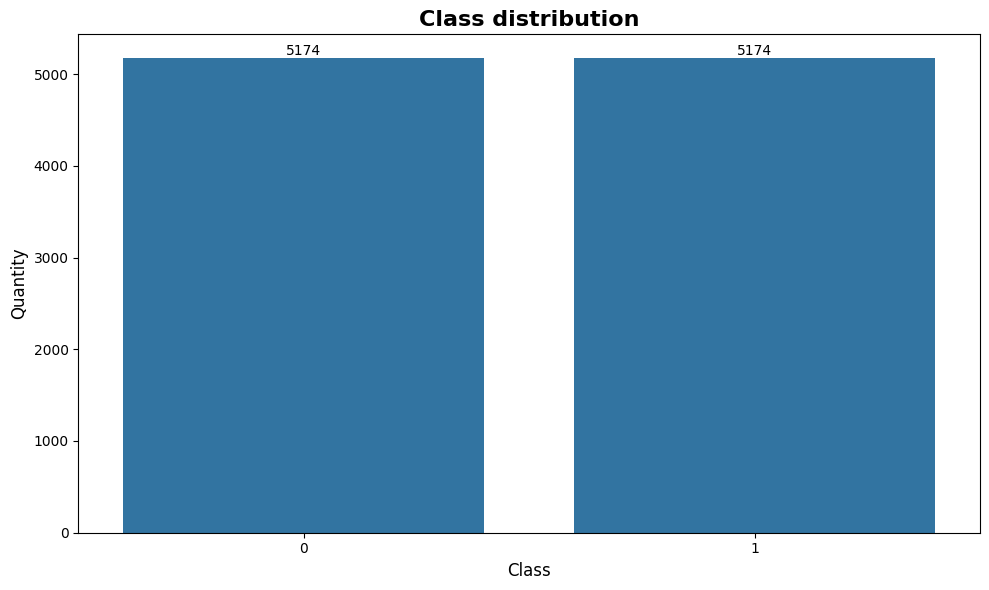

In [21]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(x=df_resampled['Class'].value_counts().index, 
                y=df_resampled['Class'].value_counts().values)

for i, v in enumerate(df_resampled['Class'].value_counts().values):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Class distribution', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Quantity', fontsize=12)

plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Con esta gráfica se muestra que el balanceo fue exitoso donde cada una de las variables muestra el mismo número de datos.

### Redistribución de las variables X e y después del proceso de balanceo

In [22]:
X_oversampled = df_resampled.drop(['Class'], axis=1)

y_oversampled_class = df_resampled["Class"]

In [23]:
X_oversampled.head()

,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand
0,1,0,0,1,0,2,0,0,0,1,2,-1.160323,-0.992611
1,0,0,1,0,2,0,2,0,1,0,3,-0.259629,-0.172165
2,0,0,1,0,2,2,0,0,0,1,3,-0.362660,-0.958066
3,0,0,0,1,2,0,2,2,1,0,0,-0.746535,-0.193672
4,0,0,1,0,0,0,0,0,0,1,2,0.197365,-0.938874


In [24]:
print(f'y_oversampled_class\n{y_oversampled_class.head()}')

y_oversampled_class
0    0
1    0
2    1
3    0
4    1
Name: Class, dtype: int64


## SELECCIÓN DEL MODELO

#### Separación del conjunto de datos en entrenamiento y prueba

In [25]:
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X_oversampled, y_oversampled_class, test_size=0.25, random_state=42
)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (7761, 13)
Tamaño del conjunto de prueba: (2587, 13)


### Modelos de clasificación

- Random Forest
- SVC
- XGBoost

In [26]:
classification_models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVC': SVC(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

### Evaluación del rendimiento de los modelos mediante métricas
#### Clasificación
- **Precisión:** Mide la proporción de predicciones correctas (tanto positivas como negativas) entre el total de casos examinados. "¿Qué porcentaje de predicciones son correctas?"

- **F1-score:** Es la media armónica de la precisión y la recuperación. Proporciona un equilibrio entre la precisión (cuántos casos clasificados como positivos son realmente positivos) y la recuperación (cuántos casos verdaderamente positivos se clasificaron correctamente).

- **Matriz de confusión:** Es una tabla que muestra las frecuencias de clasificación para cada clase del modelo. Para un problema de clasificación binaria, la matriz de confusión es una tabla 2x2.
<br><br>

|                     | **Predicción Negativa** | **Predicción Positiva** |
|---------------------|--------------------|---------------------|
| **Real Negativa**   | Verdadero Negativo (VN) | Falso Positivo (FP) |
| **Real Positiva** | Falso Negativo (FN) | Verdadero Positivo (VP)  |

<br><br>
- Verdadero Negativo (VN): El modelo predijo correctamente la clase negativa.

- Verdadero Positivo (VP): El modelo predijo correctamente la clase positiva.

- Falso positivo (FP): El modelo predijo incorrectamente la clase positiva.

- Falso negativo (FN): El modelo predijo incorrectamente la clase negativa.

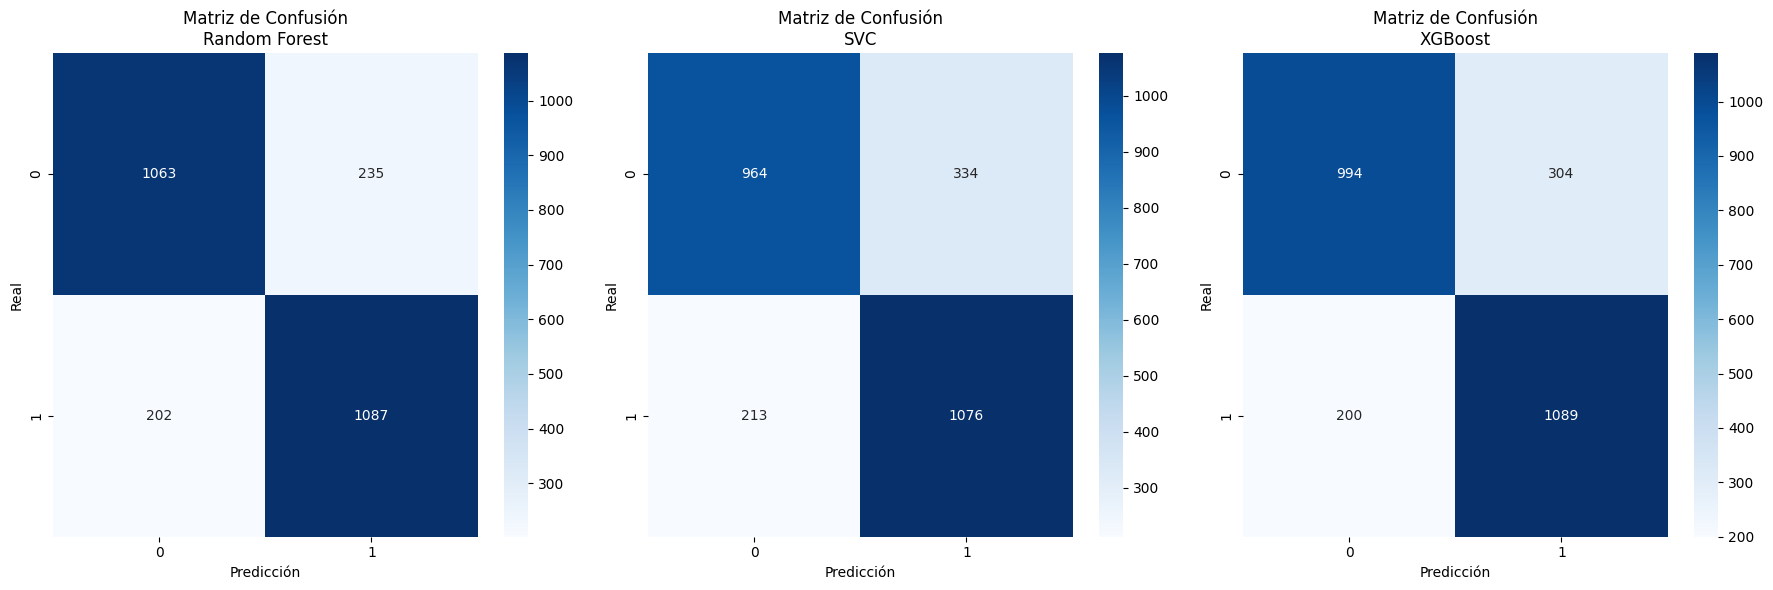

          Modelo  Accuracy  F1-Score
0  Random Forest    0.8311    0.8311
1            SVC    0.7886    0.7881
2        XGBoost    0.8052    0.8049


In [27]:

results = []

num_models = len(classification_models)
fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 6))  

if num_models == 1:
    axes = [axes]

for i, (name, model) in enumerate(classification_models.items()):
    model.fit(X_train, y_class_train)
    y_pred_class = model.predict(X_test)

    acc = accuracy_score(y_class_test, y_pred_class)
    f1 = f1_score(y_class_test, y_pred_class, average='weighted')

    results.append({
        'Modelo': name,
        'Accuracy': round(acc, 4),
        'F1-Score': round(f1, 4)
    })

    cm = confusion_matrix(y_class_test, y_pred_class)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Matriz de Confusión\n{name}')
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Real')

plt.tight_layout()
plt.show()

df_resultados = pd.DataFrame(results)
print(df_resultados)

### Evalución de las métricas

| Métrica   | Descripción                                                                 | ¿Mayor es mejor? |
|-----------|------------------------------------------------------------------------------|------------------|
| Accuracy  | Porcentaje de predicciones correctas sobre el total                         |  ☑️              |
| F1-Score  | Media armónica entre precisión y la recuperación                    | ☑️          |

Los resultados muestran que, en cuanto a precisión, el modelo `Random Forest` presenta el mejor desempeño de los tres, con valores mayores de precisión y F1-Score que los modelos `SVC` y `XGBoost`. Por lo tanto `Random Forest`, es el modelo más equilibrado y es el que se usará para la exposición de la API.



### VALIDACIÓN CRUZADA

In [28]:
best_classifier = classification_models['Random Forest']
cv_scores = cross_val_score(best_classifier, X_oversampled, y_oversampled_class, cv=5, scoring='accuracy')
print(f"Validación cruzada para la clasificación: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Validación cruzada para la clasificación: 0.8268 (+/- 0.0502)


### OPTIMIZACIÓN DE HIPERPARÁMETROS

**Optimización de los hiperparámetros del modelo de clasificación.**

In [ ]:
param_grid_classificator = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search_classificator = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_classificator, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_classificator.fit(X_oversampled, y_oversampled_class)


print("Mejores hiperparámetros para el modelo de clasificación", grid_search_classificator.best_params_)
print("Mejor precisión:", grid_search_classificator.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores parámetros para el modelo de clasificación {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mejor precisión: 0.8311805044795146


### EVALUACIÓN DEL MODELO CON LOS DATOS DE PRUEBA

In [30]:
best_classifier = grid_search_classificator.best_estimator_
y_pred_class_final = best_classifier.predict(X_test)
print("Clasificación - Accuracy:", accuracy_score(y_class_test, y_pred_class_final))
print("Clasificación - F1-score:", f1_score(y_class_test, y_pred_class_final, average='weighted'))

Clasificación - Accuracy: 0.9930421337456513
Clasificación - F1-score: 0.9930421233492441


### EXPORTACIÓN DE LOS MODELOS ENTRENADOS
La extensión para guardar los modelos entrenados es .joblib porque esta optimizda para trabajar con NumPy y scikit-learn.
Joblib está específicamente diseñada para serializar objetos que contienen grandes arreglos de datos numéricos.

In [31]:
from joblib import dump

dump(best_classifier, PATH_CLASSIFIER_MODEL)
dump(scaler, PATH_SCALER_MODEL)


['c:\\Estudio\\prueba_tecnica_gestor\\code\\models\\scaler_model.joblib']